## Imports

In [253]:
from detectron2.data.datasets import register_coco_instances
import numpy as np

In [254]:
from detectron2.data.datasets import register_coco_panoptic_separated, register_coco_panoptic, register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, Metadata
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
import cv2
import random
from detectron2.utils.visualizer import Visualizer
from thermal_dataset_mapper import ThermalDatasetMapper

In [255]:
import json
import os
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2 import model_zoo
from detectron2.config import get_cfg

## Open the original JSON File and set the paths according to your folder structure

In [256]:
json_file = open("../panopticapi/Flug1_105Media_panoptic_coco_categories copy.json")

In [257]:
categories = json.load(json_file)

In [258]:
categories

[{'supercategory': 'Thermal bridge',
  'color': [220, 20, 60],
  'isthing': 1,
  'id': 1,
  'name': 'Thermal bridge'}]

In [259]:
images_dir = "../data_thermal/test/images/Flug1_105"
#panoptic_json = "../panopticapi/Flug1_105Media_coco_panopticformat/Flug1_105Media_coco_panopticformat.json"
panoptic_root = "../panopticapi/Flug1_105Media_coco_panopticformat/Flug1_105"
sem_seg_root_train = "../panopticapi/Flug1_105Media_FPN_semantic_Mask/Flug1_105"
instances_json = "../panopticapi/Flug1_105Media_coco copy.json"

### Give the data set a name for the temporary registration

In [260]:
register_name = "Konferenz_test_thermal_panoptic17"

### Split into the categories things and stuff

In [261]:
#stuff_names=["things", "background", "sky", "other"]
#stuff_dataset_id_to_contiguous_id = {0:0, 4:1, 5:2, 3:255}

stuff_names=["things", "other"]
stuff_dataset_id_to_contiguous_id = {0:0,1:255}

In [262]:
things_names = [f["name"] for f in categories if f["isthing"] == 1]
things_ids = [f["id"] for f in categories if f["isthing"] == 1]
things_dataset_id_to_contiguous_id = dict(zip(things_ids, list(range(0, len(things_ids)))))
print(things_dataset_id_to_contiguous_id)
print(things_names)

{1: 0}
['Thermal bridge']


In [263]:
things_dataset_id_to_contiguous_id

{1: 0}

## Data set Detectron2 Registration

In [264]:
register_coco_panoptic_separated(name=register_name, metadata={}, image_root=images_dir, panoptic_root=panoptic_root, 
                                 panoptic_json=None, sem_seg_root=sem_seg_root_train, instances_json=instances_json)

In [265]:
#register_coco_panoptic(name=register_name, metadata={}, image_root=images_dir, panoptic_root=panoptic_root, panoptic_json=panoptic_json, instances_json=instances_json)

In [266]:
#register_coco_panoptic_separated(name=register_name, metadata={}, image_root=images_dir, panoptic_root=panoptic_root, panoptic_json=panoptic_json, sem_seg_root=None, instances_json=instances_json)

In [267]:
#register_coco_instances(name=register_name, metadata={}, json_file=instances_json, image_root=images_dir)

In [268]:
DatasetCatalog

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fi

### Check if the registration worked

In [269]:
DatasetCatalog.get(register_name + "_separated")
#DatasetCatalog.get(register_name)

Directory ../data_thermal/test/images/Flug1_105 and ../panopticapi/Flug1_105Media_FPN_semantic_Mask/Flug1_105 has 0 and 203 files, respectively.
Will use their intersection of 0 files.


AssertionError: 

In [ ]:
metadata_test = MetadataCatalog.get(register_name + "_separated")
metadata_test
#metadata_test = MetadataCatalog.get(register_name)

namespace(name='Konferenz_test_thermal_panoptic12_separated',
          panoptic_root='../panopticapi/Flug1_105Media_coco_panopticformat/Flug1_105',
          image_root='../data_thermal/test/images/Flug1_105',
          panoptic_json='../panopticapi/Flug1_105Media_coco_panopticformat/Flug1_105Media_coco_panopticformat.json',
          sem_seg_root='../panopticapi/Flug1_105Media_FPN_semantic_Mask/Flug1_105',
          json_file='../panopticapi/Flug1_105Media_coco copy.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          thing_classes=['Thermal bridge'],
          thing_dataset_id_to_contiguous_id={1: 0})

In [ ]:
#metadata_train = MetadataCatalog.get(register_name + "_separated").set(stuff_classes=stuff_names, stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id)

## Plot an example image

In [194]:
def plot_samples(dataset_name, n=1):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=dataset_custom_metadata, scale = 0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(15, 20))
        plt.imshow(v.get_image())
        plt.show()

In [ ]:
#def plot_samples(dataset_name, n=1):
#    dataset_custom = DatasetCatalog.get(dataset_name)
#    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

#    for s in random.sample(dataset_custom, n):
#        img = cv2.imread(s["file_name"])
#        v = Visualizer(img[:, :, ::-1], metadata=dataset_custom_metadata, scale = 0.5)
#        v = v.draw_dataset_dict(s)
#        plt.figure(figsize=(15, 20))
#        plt.imshow(v.get_image())
#        plt.show()

In [195]:
plot_samples(register_name + "_separated", n=1)

Directory ../data_thermal/test/images/Flug1_105 and ../panopticapi/Flug1_105Media_FPN_semantic_Mask/Flug1_105 has 0 and 203 files, respectively.
Will use their intersection of 0 files.


AssertionError: 

## Define the model and train it

In [139]:
cfg = get_cfg()

In [140]:
cfg.OUTPUT_DIR = "../output/instance_seg_fpn_R_101_3x"
#cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.DATASETS.TRAIN = (register_name + "_separated",)
cfg.DATASETS.TRAIN = (register_name)
cfg.MODEL.DEVICE = "cpu"
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 50    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata_train.thing_dataset_id_to_contiguous_id)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 2

In [141]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[04/15 13:03:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

The checkpoint state_dict contains keys that are not used by the model:
  backbone.bottom_up.res4.6.conv1.weight
  backbone.bottom_up.res4.6.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv2.weight
  backbone.bottom_up.res4.6.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv3.weight
  backbone.bottom_up.res4.6.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv1.weight
  backbone.bottom_up.res4.7.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv2.weight
  backbone.bottom_up.res4.7.conv2.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.7.conv3.weight
  backbone.bottom_up.res4.7.conv3.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv1.weight
  backbone.bottom_up.res4.8.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.8.conv2.weight
  backbone.bottom_up.res4.8.conv2

In [142]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cpu', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZ

In [143]:
trainer.train()

[04/15 13:04:04 d2.engine.train_loop]: Starting training from iteration 0
[04/15 13:07:20 d2.utils.events]:  eta: 0:05:01  iter: 19  total_loss: 2.092  loss_cls: 0.4827  loss_box_reg: 0.05927  loss_mask: 0.5526  loss_rpn_cls: 0.673  loss_rpn_loc: 0.3329    time: 10.0081  last_time: 7.5892  data_time: 0.0213  last_data_time: 0.0043   lr: 9.5155e-05  
[04/15 13:10:31 d2.utils.events]:  eta: 0:01:35  iter: 39  total_loss: 1.586  loss_cls: 0.3729  loss_box_reg: 0.1903  loss_mask: 0.4312  loss_rpn_cls: 0.3519  loss_rpn_loc: 0.168    time: 9.7825  last_time: 7.0306  data_time: 0.0047  last_data_time: 0.0046   lr: 0.00019506  
[04/15 13:12:20 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 1.438  loss_cls: 0.3062  loss_box_reg: 0.221  loss_mask: 0.4117  loss_rpn_cls: 0.2698  loss_rpn_loc: 0.2013    time: 9.9938  last_time: 9.7034  data_time: 0.0048  last_data_time: 0.0042   lr: 0.00024501  
[04/15 13:12:20 d2.engine.hooks]: Overall training speed: 48 iterations in 0:07:59 (9.9938 s / i

## Test data set registration

Identical to the registration before before

In [19]:
images_dir_test = "../../Dataset/Images/test"
panoptic_json_test = "../../Dataset/Annotations/panoptic_instances_test_correct_order.json"
panoptic_root_test = "../../Dataset/PanopticAPI_panoptic_Mask/test"
sem_seg_root_test = "../../Dataset/FPN_semantic_Mask/test"
instances_json_test = "../../Dataset/Annotations/instances_test2.json"

In [20]:
register_name_test = "Panoptic_Dataset_Buildings_test_fpn4"

In [21]:
stuff_dataset_id_to_contiguous_id = {0:0, 4:1, 5:2, 3:255}

In [22]:
meta_pre = {"stuff_classes": stuff_names, "stuff_dataset_id_to_contiguous_id": stuff_dataset_id_to_contiguous_id,
            "thing_dataset_id_to_contiguous_id": things_dataset_id_to_contiguous_id, "thing_classes":things_names}

In [23]:
register_coco_panoptic_separated(name=register_name_test, metadata=meta_pre, image_root=images_dir_test, panoptic_root=panoptic_root_test, panoptic_json=panoptic_json_test,
sem_seg_root=sem_seg_root_test, instances_json=instances_json_test)

In [24]:
MetadataCatalog.get(register_name_test + "_separated")#.set(stuff_classes=stuff_names, stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id)

namespace(name='Panoptic_Dataset_Buildings_test_fpn4_separated',
          panoptic_root='Dataset/mask_correct_order/test',
          image_root='Dataset/images/test',
          panoptic_json='Dataset/annotations/panoptic_instances_test_correct_order.json',
          sem_seg_root='Dataset/output_semantic_fpn/test',
          json_file='Dataset/annotations/instances_test2.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          stuff_classes=['things', 'background', 'sky', 'other'],
          stuff_dataset_id_to_contiguous_id={0: 0, 4: 1, 5: 2, 3: 255},
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             6: 3,
                                             7: 4,
                                             8: 5,
                                             9: 6,
                                             10: 7

In [25]:
DatasetCatalog.get(register_name_test + "_separated")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



[{'file_name': 'Dataset/images/test/20220121_080144_128_R_rgb_image.jpg',
  'height': 3000,
  'width': 4000,
  'image_id': 18,
  'annotations': [{'iscrowd': False,
    'bbox': [9, 1711, 3332, 1289],
    'category_id': 7,
    'segmentation': [[9.2,
      1769.7,
      801.7,
      1742.9,
      2208.6,
      1711.2,
      3335.5,
      2098.7,
      3341.4,
      2124.6,
      3332,
      2124.6,
      3328.5,
      2209.3,
      3168.5,
      2201,
      2938.6,
      2198.6,
      2540.6,
      2150.5,
      2489.5,
      2992.5,
      2251.3,
      2992.5,
      2273.8,
      2736.6,
      2175.1,
      2728.5,
      2160.2,
      2997.8,
      1719,
      2997.8,
      1724.4,
      2890.2,
      1778.2,
      2897,
      1776.1,
      2806.5,
      1632.5,
      2732.8,
      1455.1,
      2700.7,
      1314.4,
      2754.6,
      1275.4,
      2842.4,
      1319.3,
      2876.6,
      1365.7,
      2952.1,
      1338.8,
      3005.8,
      914.6,
      3000.9,
      890.2,
      2

In [26]:
#MetadataCatalog.get("Panoptic_Dataset_Buildings_train_separated")

In [27]:
#MetadataCatalog.get(register_name_test + "_separated").set(
#    thing_classes=things_names, thing_dataset_id_to_contiguous_id=things_dataset_id_to_contiguous_id)

In [28]:
metadata_test = MetadataCatalog.get(register_name_test + "_separated")

## Loading of the trained weights from before

In [29]:
##Evaluation Code
cfg.MODEL.WEIGHTS = ("../Output/segmentation_fpn_R_101_3x/model_final.pth")
cfg.DATASETS.TEST = (register_name_test + "_separated")

## Plot a new image with the predicted segmentation

In [30]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');

## Test on a new image

In [32]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25  # set the testing threshold for this model
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get(register_name_test + "_separated")
#im = cv2.imread("Dataset/images/test/20211222_094416_588_R_rgb_image.jpg")
im = cv2.imread("Dataset/Oberdorf.jpeg")
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST), scale=1.2)

/home/tahubach/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## A closer look at the predictions

In [33]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.995604395866394,
  'category_id': 0,
  'instance_id': 0},
 {'id': 2,
  'isthing': True,
  'score': 0.9950814247131348,
  'category_id': 0,
  'instance_id': 1},
 {'id': 3,
  'isthing': True,
  'score': 0.9932963252067566,
  'category_id': 0,
  'instance_id': 2},
 {'id': 4,
  'isthing': True,
  'score': 0.992021381855011,
  'category_id': 0,
  'instance_id': 3},
 {'id': 5,
  'isthing': True,
  'score': 0.9909736514091492,
  'category_id': 0,
  'instance_id': 4},
 {'id': 6,
  'isthing': True,
  'score': 0.9902162551879883,
  'category_id': 0,
  'instance_id': 5},
 {'id': 7,
  'isthing': True,
  'score': 0.9795734882354736,
  'category_id': 0,
  'instance_id': 6},
 {'id': 8,
  'isthing': True,
  'score': 0.9680001735687256,
  'category_id': 0,
  'instance_id': 7},
 {'id': 9,
  'isthing': True,
  'score': 0.9645347595214844,
  'category_id': 0,
  'instance_id': 8},
 {'id': 10,
  'isthing': True,
  'score': 0.9492660164833069,
  'category_id': 0,
  

In [41]:
panoptic_seg

tensor([[ 0,  0,  0,  ..., 26, 26, 26],
        [ 0,  0,  0,  ..., 26, 26, 26],
        [ 0,  0,  0,  ..., 26, 26, 26],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.int32)

In [42]:
import torch
torch.unique(panoptic_seg)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=torch.int32)

In [43]:
metadata_test.stuff_classes

['things', 'background', 'sky', 'other']

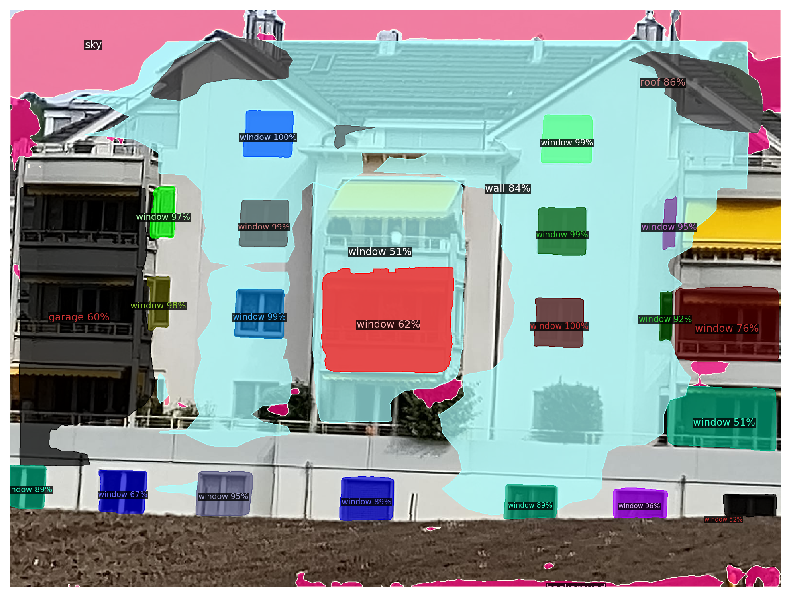

In [44]:
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])
plt.savefig("example_panoptic_image_fpn_R101_3x.png")

If the model was not loaded before, here it has to be done to evaluate the model

In [46]:
##Evaluation Code
#cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = ("../Output/segmentation_fpn_R_101_3x/model_final.pth")
cfg.DATASETS.TEST = (register_name_test +"_separated")

In [47]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25 # set threshold for this model

In [48]:
# Create predictor
predictor = DefaultPredictor(cfg)

[11/05 18:11:10 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [49]:
from detectron2.evaluation import inference_on_dataset, COCOPanopticEvaluator
from detectron2.data import build_detection_test_loader

## Evaluate with COCOPanopticEvaluator on the test set

In [50]:
# evaluate model predictions
evaluator = COCOPanopticEvaluator(register_name_test +"_separated", output_dir = "../Output/segmentation_fpn_R_101_3x/results_evaluation") #COCOEvaluator

In [51]:
DatasetCatalog.get(register_name_test +"_separated")

WARNING [11/05 18:11:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/05 18:11:11 d2.data.datasets.coco]: Loaded 5 images in COCO format from Dataset/annotations/instances_test2.json
[11/05 18:11:11 d2.data.datasets.coco]: Loaded 5 images with semantic segmentation from Dataset/images/test


[{'file_name': 'Dataset/images/test/20220121_080144_128_R_rgb_image.jpg',
  'height': 3000,
  'width': 4000,
  'image_id': 18,
  'annotations': [{'iscrowd': False,
    'bbox': [9, 1711, 3332, 1289],
    'category_id': 7,
    'segmentation': [[9.2,
      1769.7,
      801.7,
      1742.9,
      2208.6,
      1711.2,
      3335.5,
      2098.7,
      3341.4,
      2124.6,
      3332,
      2124.6,
      3328.5,
      2209.3,
      3168.5,
      2201,
      2938.6,
      2198.6,
      2540.6,
      2150.5,
      2489.5,
      2992.5,
      2251.3,
      2992.5,
      2273.8,
      2736.6,
      2175.1,
      2728.5,
      2160.2,
      2997.8,
      1719,
      2997.8,
      1724.4,
      2890.2,
      1778.2,
      2897,
      1776.1,
      2806.5,
      1632.5,
      2732.8,
      1455.1,
      2700.7,
      1314.4,
      2754.6,
      1275.4,
      2842.4,
      1319.3,
      2876.6,
      1365.7,
      2952.1,
      1338.8,
      3005.8,
      914.6,
      3000.9,
      890.2,
      2

In [52]:
val_loader = build_detection_test_loader(cfg, register_name_test +"_separated")

WARNING [11/05 18:11:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/05 18:11:11 d2.data.datasets.coco]: Loaded 5 images in COCO format from Dataset/annotations/instances_test2.json
[11/05 18:11:11 d2.data.datasets.coco]: Loaded 5 images with semantic segmentation from Dataset/images/test
[11/05 18:11:11 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   window   | 42           |    door    | 5            |    wall    | 5            |
|    pipe    | 12           |    vent    | 4            |    roof    | 6            |
|  balcony   | 2            |   garage   | 4            |            |              |
|   total    | 80           |            |              |            |              |
[11/05 18:11:11 d2.data.dataset_mapper]

In [53]:
eval_results=inference_on_dataset(predictor.model, val_loader, evaluator)

[11/05 18:11:14 d2.evaluation.evaluator]: Start inference on 5 batches
[11/05 18:11:35 d2.evaluation.evaluator]: Total inference time: 0:00:04.049910 (4.049910 s / iter per device, on 1 devices)
[11/05 18:11:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (2.954631 s / iter per device, on 1 devices)
[11/05 18:11:35 d2.evaluation.panoptic_evaluation]: Writing all panoptic predictions to /tmp/panoptic_eval7d8niyvt ...
[11/05 18:12:21 d2.evaluation.panoptic_evaluation]: Panoptic Evaluation Results:
|        |   PQ   |   SQ   |   RQ    |  #categories  |
|:------:|:------:|:------:|:-------:|:-------------:|
|  All   | 47.260 | 56.891 | 56.785  |      10       |
| Things | 36.597 | 48.636 | 45.981  |       8       |
| Stuff  | 89.910 | 89.910 | 100.000 |       2       |


In [54]:
eval_results

OrderedDict([('panoptic_seg',
              {'PQ': 47.25992080231123,
               'SQ': 56.89067609290497,
               'RQ': 56.78508771929825,
               'PQ_th': 36.597456115935586,
               'SQ_th': 48.63590022917777,
               'RQ_th': 45.98135964912281,
               'PQ_st': 89.90977954781377,
               'SQ_st': 89.90977954781377,
               'RQ_st': 100.0})])

## Tensorboard to visualize the training

In [52]:
%reload_ext tensorboard

In [54]:
%tensorboard --logdir ../Output/segmentation_fpn_R_101_3x